In [208]:
#from PyQt5.QtWidgets import *
#from PyQt5.QtGui import *
#from PyQt5.QtCore import Qt
import os
from array import array
import numpy as np
from commpy.filters import rcosfilter
from commpy.filters import rrcosfilter
import matplotlib
import matplotlib.pyplot as plt
import ipympl
#%matplotlib inline
%matplotlib widget

In [209]:
#import matplotlib
#import matplotlib.pyplot as plt
#import numpy as np
#import cmath
#import math
#from commpy.filters import rcosfilter
#from ipywidgets import interact, widgets

In [210]:
from scipy.signal import butter, filtfilt
import os
from array import array
def read_signal(file_name, data_type):
    file_stats = os.stat(file_name)
    file_size = file_stats.st_size
    iq_size_in_bytes = 4
    number_of_int_to_read = file_size // iq_size_in_bytes * 2
    arr = array(data_type)
    with open(file_path, 'rb') as fileobj:
        arr.fromfile(fileobj, number_of_int_to_read)
    i = np.array(arr[:: 2])
    i = i.reshape((len(i), 1))
    q = np.array(arr[1:: 2])
    q = q.reshape((len(q), 1))
    sig = np.empty((len(i), 1), complex)
    sig.real = i
    sig.imag = q
    sig_flatten = sig.flatten()
    return sig_flatten


def find_carr_freq(spectrum, min_sig_lvl):
    idx = list(np.where(spectrum >= min_sig_lvl))
    idx = idx[0]
    f_low = idx[0]
    f_high = idx[-1]
    carr_freq = round((f_low + f_high) / 2)
    return carr_freq


def mixing_signal(signal, freq):
    N = len(signal)
    k = freq
    n = np.arange(0, N, 1)
    mixer = np.exp(-1j * 2 * math.pi * k * n / N)
    mixed_signal = np.multiply(signal, mixer)
    return mixed_signal


def filter_signal(mixed_sig, normal_cutoff):
    order = 2
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    sig_filtered = filtfilt(b, a, mixed_sig)
    return sig_filtered

In [211]:
def resampling_lagrange_step_ver(s, step, x0):
    """
    % y = resample_lagrange(s, p, q, x0)
    % Digital resampling by polynomial Lagrange interpolation.
    % Function changes input signal s samplerate to p/q times and adds fractional
    % delay.
    %
    % Input parameters
    %  s   - input signal vector [N x 1];
    %  p   - p paramter of samplarate conversion
    %  q   - q paramter of samplarate conversion
    %  x0  - fractional delay
    %
    % Ouptut parameters
    %  y   - Resampled signal
    %
    % Author: Sergey Bakhurin (dsplib.org)
    """
    #if (p > 1):
    #    if (q == 1):
    #        y = np.zeros(int(float((len(s) - 1) * p) / float(q)) + 1, dtype=np.csingle)
    #    else:
    #        y = np.zeros(int(float(len(s) * p) / float(q)), dtype=np.csingle)
    #else:
    #    y = np.zeros(int(float(len(s) * p) / float(q)), dtype=np.csingle)
    if (step > 1):
        y = np.zeros(int((len(s) -1) / step) + 1, dtype=np.csingle)
    else:
        y = np.zeros(int(len(s) / step), dtype=np.csingle) 
    
    t = np.zeros(len(y))
    s = np.concatenate((np.array([0., 0.]), s, np.array([0., 0.])))

    print(f"len(y) = {len(y)}, len(t) = {len(t)}, len(s) = {len(s)}")

    for k in range(len(y)):
        #x = k * q / p - x0
        x = k * step - x0
        t[k] = x
        n = int(np.floor(x)) + 4
        d = np.floor(x) + 1 - x
        #print(f"x = {x}, n = {n}, d = {d}")
        a0 = s[n - 1]
        a3 = 1 / 6 * (s[n] - s[n - 3]) + 0.5 * (s[n - 2] - s[n - 1])
        a1 = 0.5 * (s[n] - s[n - 2]) - a3
        a2 = s[n] - s[n - 1] - a3 - a1
        #print(f"a0 = {a0} a1 = {a1} a2 = {a2} a3 = {a3}")
        y[k] = a0 - a1 * d + a2 * d ** 2 - a3 * d ** 3

    #print(t)
    return y

In [212]:
def resampling_lagrange(s, p, q, x0):
    """
    % y = resample_lagrange(s, p, q, x0)
    % Digital resampling by polynomial Lagrange interpolation.
    % Function changes input signal s samplerate to p/q times and adds fractional
    % delay.
    %
    % Input parameters
    %  s   - input signal vector [N x 1];
    %  p   - p paramter of samplarate conversion
    %  q   - q paramter of samplarate conversion
    %  x0  - fractional delay
    %
    % Ouptut parameters
    %  y   - Resampled signal
    %
    % Author: Sergey Bakhurin (dsplib.org)
    """
    if (p > 1):
        if (q == 1):
            y = np.zeros(int(float((len(s) - 1) * p) / float(q)) + 1, dtype=np.csingle)
        else:
            y = np.zeros(int(float(len(s) * p) / float(q)), dtype=np.csingle)
    else:
        y = np.zeros(int(float(len(s) * p) / float(q)), dtype=np.csingle)

    t = np.zeros(len(y))
    s = np.concatenate((np.array([0., 0.]), s, np.array([0., 0.])))

    for k in range(len(y)):
        x = k * q / p - x0
        t[k] = x
        n = int(np.floor(x)) + 4
        d = np.floor(x) + 1 - x
        a0 = s[n - 1]
        a3 = 1 / 6 * (s[n] - s[n - 3]) + 0.5 * (s[n - 2] - s[n - 1])
        a1 = 0.5 * (s[n] - s[n - 2]) - a3
        a2 = s[n] - s[n - 1] - a3 - a1

        y[k] = a0 - a1 * d + a2 * d ** 2 - a3 * d ** 3

    return y


In [213]:
def calculate_spectrum(signal):
    yf = np.fft.fft(signal)
    yf = np.abs(yf.reshape((len(yf), 1))) / len(signal)
    return yf


def plot_spectrum(signal, figure_counter, title="Amplitude spectrum"):
    spectrum = np.roll(calculate_spectrum(signal), len(signal) // 2)
    yf = 20 * np.log10(spectrum)

    plt.figure(figure_counter)
    plt.cla()
    x_data = np.arange(-len(spectrum) // 2 + 1, len(spectrum) // 2 + 1)
    x_data = x_data / (len(spectrum) / 2)
    plt.plot(x_data, yf)
    plt.grid(1)
    plt.xlabel('Frequency (semicircles)')
    plt.ylabel('Magnitude (dB)')
    plt.title(title)
    plt.show()
    return yf

def add_freq(sig, f0_to_fsig):
    n = np.arange(0, len(sig), 1)
    mixer = np.exp(1j * np.pi * f0_to_fsig * n)
    #print(mixer[(821500 - 10 -1) : (821500 - 1)])
    return sig * mixer

In [214]:
def gen_rrc_filter_impulse_response(n, f_sampl, t_symb, roll_off=0.24):
    print(n * f_sampl)
    print(roll_off)
    print(t_symb)    
    print(f_sampl)
    
    s_psf = rrcosfilter(n * f_sampl, roll_off, Ts=t_symb, Fs=f_sampl)[1][1:]
    print(s_psf)
    #plt.figure()
    #plt.plot(s_psf, '*-')
    #plt.grid()
    #plt.title('RC filter impulse response')
    #plt.show()
    return s_psf

In [215]:
def gen_rc_filter_impulse_response(n, f_sampl, t_symb, roll_off=0.24):
    #print(n * f_sampl)
    #print(roll_off)
    #print(t_symb)    
    #print(f_sampl)
    
    s_psf = rcosfilter(n * f_sampl, roll_off, Ts=t_symb, Fs=f_sampl)[1][1:]
    #print(s_psf)
    #plt.figure()
    #plt.plot(s_psf, '*-')
    #plt.grid()
    #plt.title('RC filter impulse response')
    #plt.show()
    return s_psf

In [216]:
def add_phase(sig, phase):
# phase = [-1, 1] [semicircles]
    sig *= np.exp(1j * np.pi * phase)
    return sig

In [217]:
def save_cmplx_sig_to_int16(signal, filename):
    s_re = signal.real
    s_im = signal.imag
    arr_int16_re = s_re.astype(np.int16)
    arr_int16_im = s_im.astype(np.int16)
    arr_int = np.empty(len(two_sigs) * 2, dtype=int)
    print(len(arr_int))
    arr_int[ : : 2] = arr_int16_re
    arr_int[1 : : 2] = arr_int16_im
    saved_arr = arr_int.astype(np.int16)
    print(saved_arr[:30])
    with open(filename, 'wb') as f:
        saved_arr.tofile(f)

In [218]:
def gen_qpsk_symbols(n_symb, fs):
    # create IQ of QPSK
    # complex array: [(1 + 1j, 1 -1j, ..., -1 -1j)]
    data = np.random.randint(0, 4, n_symb)
    #print(len(data))
    #x_tr = x.transpose()
    y = [-1 - 1j, -1 + 1j, 1 - 1j, 1 + 1j]
    iq = [y[val] for val in data]
    iq_ups = np.zeros(n_symb * fs, dtype=complex)
    iq_ups[:len(iq) * fs:fs] = iq
    return iq_ups

In [219]:
def plot_signal_power(signal, figure_counter, title="Signal Power"):
    plt.figure(figure_counter)
    plt.cla()
    x_data = np.arange(0, len(signal))
    plt.plot(x_data, signal)
    plt.grid(1)
    plt.xlabel('time (samples)')
    plt.ylabel('Signal Power')
    plt.title(title)
    plt.show()

def upscale_to_i16(signal):
    max_i16 = 32767
    print(max(signal))
    print(max(signal.real))
    print(max(signal.imag))
    coeff = max_i16 / max(max(signal.real), max(signal.imag))
    print(coeff)
    return signal * np.floor(coeff)

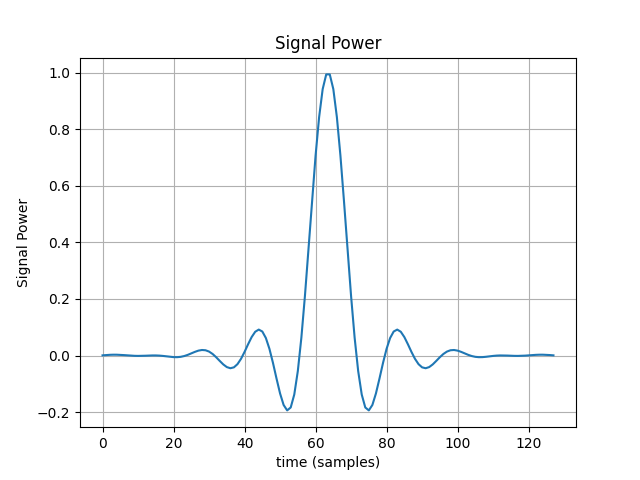

In [248]:
sig_board = 0.168
N = 129#100
Fs = 1
T_symb = 8#1 / sig_board
s_rc = gen_rc_filter_impulse_response(N, Fs, T_symb)
plot_signal_power(s_rc, 0)


f0 = 2.5 # f_carrier / f_symbol
phase_0 = 3 / 9 # semicircles
delay = 0.1

N_symb = N * 50000
sps = 8 # f_sampling / f_symbol (SPS)
s_qpsk = gen_qpsk_symbols(N_symb, sps)
qpsk_rc = np.convolve(s_qpsk, s_rc, 'same')


In [249]:

mixed_qpsk = add_freq(qpsk_rc, 0.5)
mixed_qpsk = add_phase(mixed_qpsk, 0.3)

In [250]:
two_sigs = mixed_qpsk + qpsk_rc
two_sigs = upscale_to_i16(two_sigs)

(4.601505814829287-1.445256891866235j)
4.601505814829287
4.614739855200526
7100.5085937994145


In [251]:
save_cmplx_sig_to_int16(two_sigs, 'qpsk_rc_int16_.bin')

103200000
[17002 -6668  5145  3105  -417 -8065 13014 -8393 12124  7112  -235  5118
  7164 -4065 17113  7339  5648 17083 -2693  5451  7553 -3260 14947  3085
  9791  8312  1857  3994   279 -7123]


In [252]:
print(max(two_sigs))

(32670.69128528794-10261.323932250269j)


In [253]:
print(N)
print(Fs)
print(T_symb)
s_rrc = gen_rrc_filter_impulse_response(N, Fs, T_symb)
qpsk_rrc = np.convolve(s_qpsk, s_rrc, 'same')
mixed_qpsk = add_freq(qpsk_rrc, 0.5)
mixed_qpsk = add_phase(mixed_qpsk, 0.3)
two_sigs = mixed_qpsk + qpsk_rrc
two_sigs_upsc = upscale_to_i16(two_sigs)
save_cmplx_sig_to_int16(two_sigs_upsc, 'qpsk_rrc_int16_.bin')

129
1
8
129
0.24
8
1
[-4.78432985e-03 -2.92888802e-03 -2.14794103e-04  2.79869700e-03
  5.44009820e-03  7.07437816e-03  7.25347081e-03  5.83361588e-03
  3.02988449e-03 -6.09175616e-04 -4.30644403e-03 -7.22182436e-03
 -8.64421740e-03 -8.16693557e-03 -5.80431689e-03 -2.01781383e-03
  2.36151913e-03  6.30411024e-03  8.81389329e-03  9.17174565e-03
  7.13396128e-03  3.03492943e-03 -2.23909176e-03 -7.41133315e-03
 -1.10864888e-02 -1.20808018e-02 -9.73906938e-03 -4.16303029e-03
  3.71211910e-03  1.22285847e-02  1.93011886e-02  2.28520476e-02
  2.13034607e-02  1.40253416e-02  1.63129384e-03 -1.39621420e-02
 -2.97575362e-02 -4.21694002e-02 -4.77184585e-02 -4.38071755e-02
 -2.94247431e-02 -5.62570329e-03  2.43465865e-02  5.53647686e-02
  8.11477222e-02  9.53300914e-02  9.27099021e-02  7.04613405e-02
  2.90831942e-02 -2.71219336e-02 -9.01780589e-02 -1.49220853e-01
 -1.91870922e-01 -2.06020876e-01 -1.81776398e-01 -1.13245524e-01
  1.26027511e-04  1.52920329e-01  3.33960482e-01  5.27389309e-01
  7.

(15.751600567175448+9.210211944222976j)
15.751600567175448
15.74354340621259
2080.233044271242
103200000
[11164 -7563 13333 -6558 15210 -4507 16697 -1516 17714  2129 18263  5983
 18433  9559 18316 12406 17974 14095 17518 14277 17083 12826 16732  9857
 16472  5634 16335   591 16319 -4650]


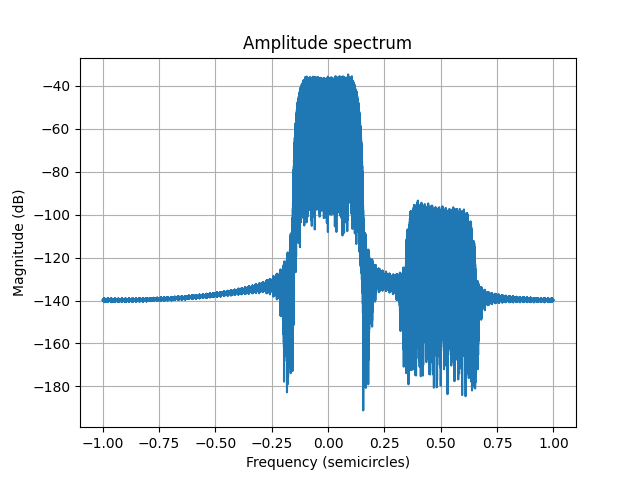

array([[-139.8519014 ],
       [-139.85190144],
       [-139.85190135],
       ...,
       [-139.85190145],
       [-139.85190095],
       [-139.85190141]])

In [254]:
qpsk_rrc_rrc = np.convolve(two_sigs, s_rrc, 'same')
two_sigs_upsc = upscale_to_i16(qpsk_rrc_rrc)
save_cmplx_sig_to_int16(two_sigs_upsc, 'qpsk_rrc_rrc_int16_.bin')

plot_spectrum(qpsk_rrc_rrc, 1)

(1.9366434157046468+1.8056436533560323j)
1.9366434157046468
1.9366434157046468
16919.480237965097


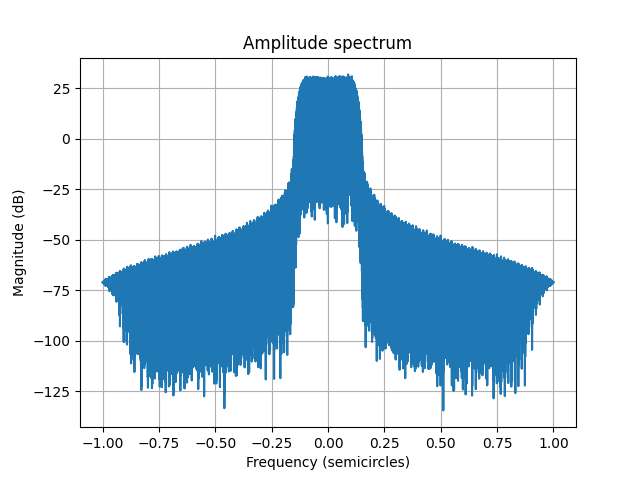

array([[-70.9585696 ],
       [-70.95856959],
       [-70.95857036],
       ...,
       [-70.9585688 ],
       [-70.9585719 ],
       [-70.95856929]])

In [255]:
qpsk_upsc = upscale_to_i16(qpsk_rc)
plot_spectrum(qpsk_upsc, 2)

In [256]:
save_cmplx_sig_to_int16(qpsk_upsc, 'qpsk_rc_int16_1_sig.bin')

103200000
[ 16209 -18267  17519 -15166  18363 -10586  18755  -4961  18764   1113
  18488   6961  18044  11909  17548  15370  17101  16925  16782  16373
  16625  13777  16614   9462  16712   3959  16860  -2053  16991  -7835]
